In [1]:
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
print('Scanpy version:', sc.__version__)

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

Scanpy version: 1.9.1


/var/folders/fr/z238tpm931s466144gcdpdj40000gn/T/ipykernel_20016/1644390834.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# !pip install scperturb --upgrade
# from scperturb import *

In [4]:
import sys
sys.path.append("..")
%reload_ext autoreload
%autoreload 2
from src.scperturb import *

# Prepare the data

In [5]:
# !wget https://zenodo.org/record/7041849/files/DatlingerBock2021.h5ad
adata = sc.read('DatlingerBock2021.h5ad')
adata

AnnData object with n_obs × n_vars = 39194 × 25904
    obs: 'sample', 'cell_line', 'perturbation', 'perturbation_2', 'tissue_type', 'cancer', 'celltype', 'disease', 'organism', 'perturbation_type', 'perturbation_type_2', 'ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [6]:
if 'processed' in adata.uns.keys():
    print('The dataset is already processed. Skipping processing...')
else:
    adata.layers['counts'] = adata.X.copy()

    # basic qc and pp
    sc.pp.filter_cells(adata, min_counts=1000)
    sc.pp.normalize_per_cell(adata)
    sc.pp.filter_genes(adata, min_cells=50)
    sc.pp.log1p(adata)

    # high class imbalance
    adata = equal_subsampling(adata, 'perturbation', N_min=200)
    sc.pp.filter_genes(adata, min_cells=3)  # sanity cleaning

    # select HVGs
    n_var_max = 2000  # max total features to select
    sc.pp.highly_variable_genes(adata, n_top_genes=n_var_max, subset=False, flavor='seurat_v3', layer='counts')
    sc.pp.pca(adata, use_highly_variable=True)
    sc.pp.neighbors(adata)

    adata.uns['processed'] = True

# E-distance

In [13]:
# Compute E-distances
estats = edist(adata, obs_key='perturbation', obsm_key='X_pca', dist='sqeuclidean', correction_factor=False)

100%|██████████| 31/31 [00:00<00:00, 101.70it/s]


In [14]:
# square matrix, all pairs of perturbations get an e-distance
estats.head()

perturbation,control,LAT_2,LCK_2,JUND_2,ZAP70_2,FOS_2,EGR3_2,EGR4_1,PTPN11_2,LAT_1,...,NFAT5_2,EGR2_2,DOK2_2,FOS_1,LCK_1,PTPN6_2,NR4A1_1,ZAP70_1,RUNX2_2,JUN_2
perturbation,,,,,,,,,,,,,,,,,,,,,
control,0.000000,1.559498,1.034070,0.457109,2.387216,0.093598,0.478526,0.147876,0.966684,2.915173,...,0.084596,0.409577,0.408293,1.485413,2.091806,0.789556,0.974710,2.145795,0.758200,1.447004
LAT_2,1.559498,0.000000,0.208348,0.209601,-0.023980,0.708662,0.452281,1.825731,1.490014,0.449166,...,1.070097,0.305448,0.536589,0.180564,0.451558,1.298964,1.198401,0.631421,0.385143,0.227437
LCK_2,1.034070,0.208348,0.000000,0.279249,0.482864,0.392875,0.208821,1.072727,0.527004,0.466840,...,0.831114,0.157476,0.168842,0.027802,0.197411,0.488675,0.449946,0.270434,0.382162,0.063383
JUND_2,0.457109,0.209601,0.279249,0.000000,0.563902,0.163302,0.162876,0.840525,0.894459,1.068079,...,0.343155,0.005827,0.100997,0.482070,0.805015,0.777133,0.756772,0.873154,0.167000,0.378704
ZAP70_2,2.387216,-0.023980,0.482864,0.563902,0.000000,1.270412,0.823802,2.481305,1.769164,0.214835,...,1.723271,0.680284,0.991922,0.283429,0.313448,1.629477,1.420656,0.445501,0.622884,0.297467


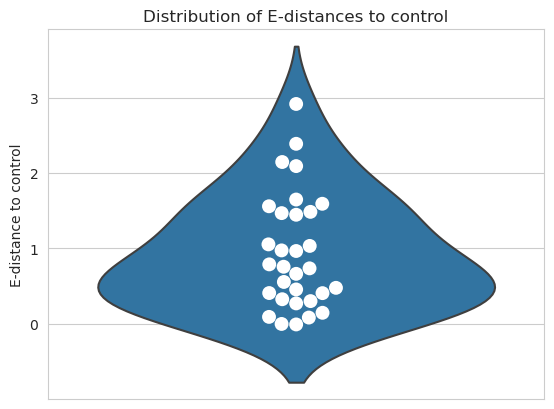

In [15]:
with sns.axes_style('whitegrid'):
    sns.violinplot(data=estats.loc['control'], inner=None)
    sns.swarmplot(data=estats.loc['control'], size=10, color='white')
pl.xticks([0], [''])
pl.ylabel('E-distance to control')
pl.title('Distribution of E-distances to control')
pl.show()

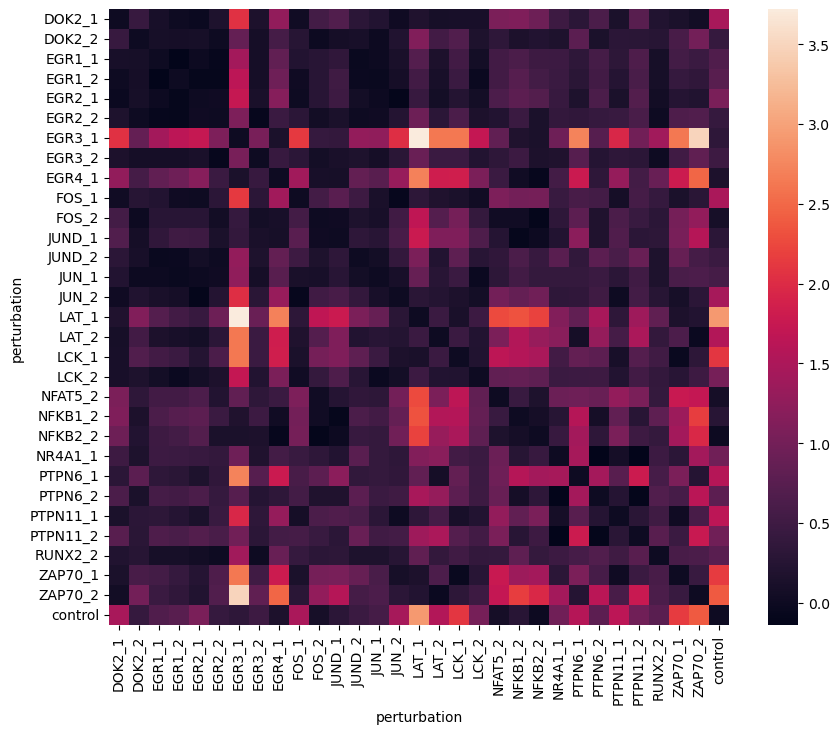

In [16]:
fig, ax = pl.subplots(1,1, figsize=[10,8])
order = estats.sort_index().index
sns.heatmap(estats.loc[order, order])
pl.show()

# E-testing

In [13]:
# e-testing (can be slow)
df = etest(adata, obs_key='perturbation', obsm_key='X_pca', dist='sqeuclidean', control='control', alpha=0.05, runs=1000)

100%|██████████| 1000/1000 [00:12<00:00, 80.61it/s]


In [14]:
df.head()

,edist,pvalue,significant,pvalue_adj,significant_adj
DOK2_1,2.049532,0.001,True,0.030539,True
DOK2_2,0.833573,0.002,True,0.030539,True
EGR1_1,1.537348,0.001,True,0.030539,True
EGR1_2,1.635644,0.001,True,0.030539,True
EGR2_1,2.022106,0.001,True,0.030539,True


In [16]:
df.head()

,edist,pvalue,significant,pvalue_adj,significant_adj
DOK2_1,2.049532,0.001,True,0.030539,True
DOK2_2,0.833573,0.002,True,0.030539,True
EGR1_1,1.537348,0.001,True,0.030539,True
EGR1_2,1.635644,0.001,True,0.030539,True
EGR2_1,2.022106,0.001,True,0.030539,True


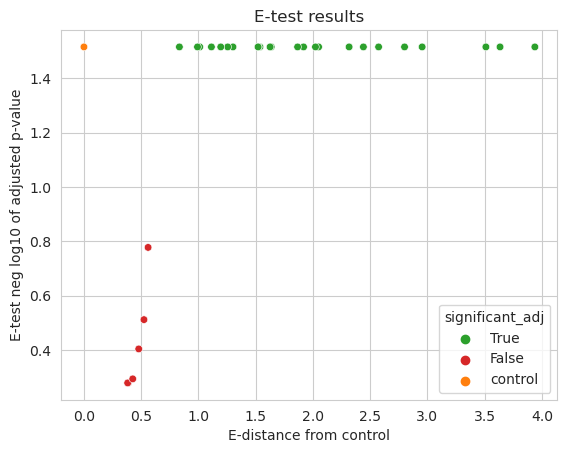

In [19]:
df.loc[df.index=='control', 'significant_adj'] = 'control'
df['neglog10_pvalue_adj'] = -np.log10(df['pvalue_adj'])
with sns.axes_style('whitegrid'):
    sns.scatterplot(data=df, y='neglog10_pvalue_adj', x='edist', hue='significant_adj', palette={True: 'tab:green', False: 'tab:red', 'control': 'tab:orange'}, s=30)
pl.title('E-test results')
pl.xlabel('E-distance from control')
pl.ylabel('E-test neg log10 of adjusted p-value')
pl.show()

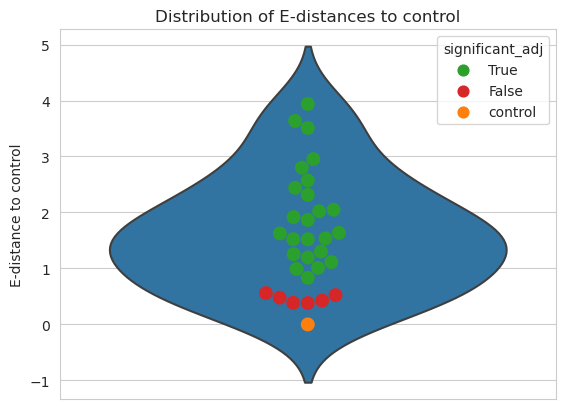

In [20]:
with sns.axes_style('whitegrid'):
    sns.violinplot(data=df, y='edist', inner=None)
    sns.swarmplot(data=df, x=[0]*len(df), y='edist', size=10, hue='significant_adj', dodge=False, palette={True: 'tab:green', False: 'tab:red', 'control': 'tab:orange'})
pl.xticks([0], [''])
pl.ylabel('E-distance to control')
pl.title('Distribution of E-distances to control')
pl.show()